##### Исследование данных сервиса аренды самокатов GoFast

Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться
без подписки и с подпиской.

**Цель исследования:**
1. Выяснить, выгоднее ли для компании большее количество пользователей с подпиской.
2. Выяснить, увеличен ли износ самокатов из-за неоптимальной средней дальности поездок (используют ли пользователи самокаты дольше оптимального по износостойкости значения).
3. Определить основную целевую аудиторию (возраст, город).

**Ход исследования:**

Данные о пользователях, поездках и тарифах я получу из трех файлов: users_go.csv, rides_go.csv и subscriptions_go.csv. Данные будут проверены мной на пропуски и дубликаты, в случае их наличия будут удалены или заменены оптимальными для конкретной ситуации значениями.

Данные из трех таблиц будут объединены в одну для удобства исследования. Будут построены графики и гистограммы по исследуемым показателям: длительность и дальность поездок для пользователей без посписки и с, возраст пользователей, города, соотношения пользователей с подпиской и без. Графики будут проанализированы, будут обозначены средние значения и отклонения каждого показателя. 

Будет добавлен новый столбец с расчетом помесячной выручки каждого отдельного пользователя.

Будут проверены гипотезы о дальности поездок пользователей без подписки и с, а также выручки с пользователей указанных типов и гипотезы о равенстве средней дальности поездки оптимальному по износостойкости значению.

Этапы исследования:
1. Обзор данных
2. Преобработка данных
3. Исследовательский анализ данных
4. Объединение данных
5. Подсчёт выручки
6. Проверка гипотез
7. Общий вывод

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

#### Шаг 1. Загрузка данных

In [2]:
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')

In [3]:
users.head(10)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [5]:
rides.head(10)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


In [6]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [7]:
subscriptions.head(10)

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [8]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


##### Вывод по общей информации

1) Есть три таблицы по данным, которые было бы удобнее объединить в одну.

2) По первым 10 строкам не видно пропусков, но стоит проверить (за исключением таблицы subscriptions, так как её мы увидели полностью).

3) Стоит проверить столбец city таблицы users на наличиее дубликатов.

4) Столбец date таблицы rides имеет тип данных object, что следует заменить на тип datetime.

#### Шаг 2. Предобработка данных

In [9]:
# приведем столбец date к типу даты pandas

rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')
rides.dtypes

user_id              int64
distance           float64
duration           float64
date        datetime64[ns]
dtype: object

In [10]:
# создадим новый столбец с номером месяца на основе столбца date

rides['month'] = rides['date'].dt.month
rides.head(10)

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8
5,1,2770.890808,16.650138,2021-10-09,10
6,1,3039.020292,14.927879,2021-10-19,10
7,1,2842.118050,23.117468,2021-11-06,11
8,1,3412.690668,15.238072,2021-11-14,11
9,1,748.690645,15.041884,2021-11-22,11


In [11]:
rides['date'].dt.year.unique()

array([2021])

В датасете данные только за 2021 год.

In [12]:
# проверим наличие пропущенных значений

users.isnull().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [13]:
rides.isnull().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [14]:
users['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

In [15]:
print(f"Дубликатов в таблице users: {users[users.duplicated()]['user_id'].count()}\n\
Дубликатов в таблице rides: {rides[rides.duplicated()]['user_id'].count()}")

Дубликатов в таблице users: 31
Дубликатов в таблице rides: 0


In [16]:
# удалим явные дубликаты из users

users = users.drop_duplicates()
users

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
...,...,...,...,...,...
1529,1530,Ростислав,29,Сочи,free
1530,1531,Никита,25,Пятигорск,free
1531,1532,Алексей,26,Тюмень,free
1532,1533,Степан,22,Краснодар,free


##### Вывод
1. Столбец date приведен к типу даты pandas
2. Создан новый столбец month с номером месяца на основе столбца date
3. Данные не содержат пропусков и неявных дубликатов.
4. Датафреймы users и rides были проверены на наличие явных дубликатов.  Явные дубликаты были найдены в users.
5. Из датафреейма users был удалеен 31 явный дубликат.

#### Шаг 3. Исследовательский анализ данных

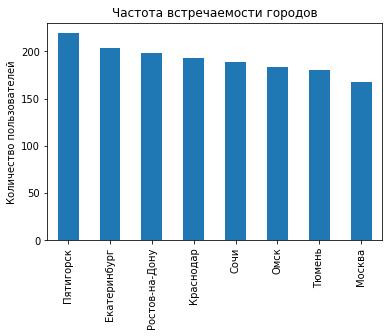

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

In [17]:
# частота встречаемости городов

users['city'].value_counts().plot.bar()
plt.title('Частота встречаемости городов')
plt.ylabel('Количество пользователей')
plt.show()
users['city'].value_counts()

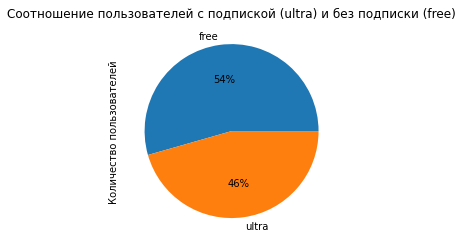

In [18]:
# соотношение пользователей с подпиской (ultra) и без подписки (free)

users['subscription_type'].value_counts().plot(kind='pie',  y='points', autopct='%1.0f%%')
plt.title('Соотношение пользователей с подпиской (ultra) и без подписки (free)')
plt.ylabel('Количество пользователей')
plt.show()

Пользователей без подписки оказалось 54% от общего числа пользователей. Пользователей с подпиской немного меньше - 46%.

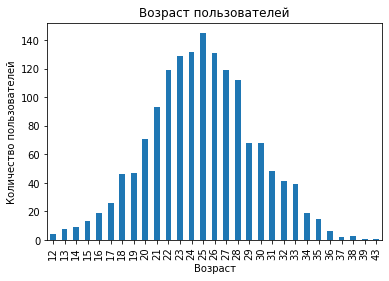

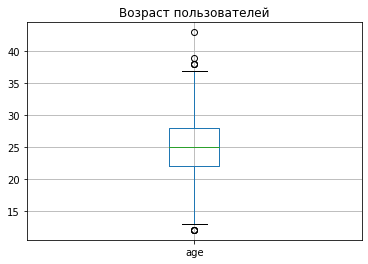

In [19]:
# возраст пользователей

users['age'].value_counts(sort=False).plot.bar()
plt.title('Возраст пользователей')
plt.ylabel('Количество пользователей')
plt.xlabel('Возраст')
plt.show()

users.boxplot('age')
plt.title('Возраст пользователей')
plt.show()

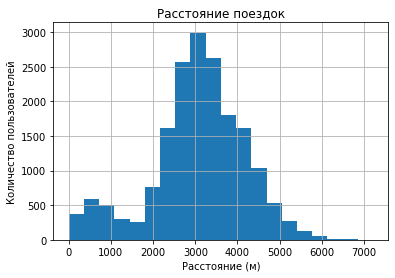

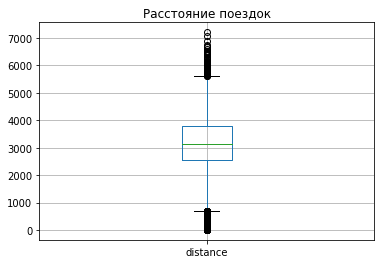

In [20]:
# расстояние, которое пользователь преодолел за одну поездку

rides['distance'].hist(bins=20)
plt.title('Расстояние поездок')
plt.ylabel('Количество пользователей')
plt.xlabel('Расстояние (м)')
plt.show()

rides.boxplot('distance')
plt.title('Расстояние поездок')
plt.show()

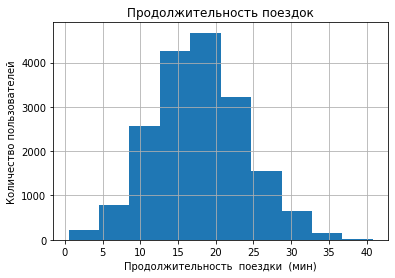

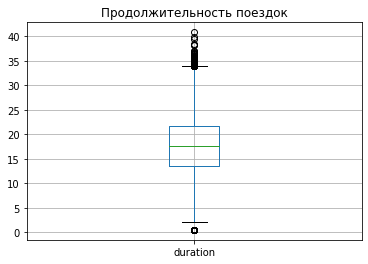

In [21]:
# продолжительность поездок

rides['duration'].hist()
plt.title('Продолжительность поездок')
plt.ylabel('Количество пользователей')
plt.xlabel('Продолжительность  поездки  (мин)')
plt.show()

rides.boxplot('duration')
plt.title('Продолжительность поездок')
plt.show()

##### Вывод

1. Указанные города Тюмень, Омск, Москва, Ростов-на-Дону, Краснодар, Пятигорск, Екатеринбург, Сочи встречаются в данных с приблизительно одинаковой частотой. Чаще всего встречается Пятигорск (226 пользователей указали данный город), реже всего - Москва (172 упоминания). Остальные города упоминаются 185-206 раз.

2. Пользователей без подписки оказалось 54% от общего числа пользователей. Пользователей с подпиской немного меньше - 46%.

Тип подписки | Доля от общего числа
:----------- | :-------------------
free         | 54%
ultra        | 46%

3. Возраст пользователей распределен нормально. Средний возраст пользователя равен 25 лет. Всего в данных встречаются пользователи в возрасте от 12 до 43 лет включительно. 95% пользователей будет в диапазоне 16-35 лет.

4. На графике расстояния видно два пика:  3100 и 500  метров. Полагаю, пик в 500 метров связан с неработающими/плохо  работающими самокатами или же пользователями, передумавшими совершать поездку или просто желающими попробовать встать на самокат. То есть, скорее всего, эти поездки не являются полноценными. Если не смотреть на пик в 500 метров, то распределение расстояний похоже на нормальное с мат. ожиданием 3100 метров и стандартным отклонением около 1200 метров, то есть 95% полноценных поездок будут в диапазоне 800-5400 метров. Самые далекие поездки совершаются  на расстояние до 7000 метров.

#### Шаг 4. Объединение данных

In [22]:
print(f'Кол-во строк в users: {users.shape[0]}\n\
Кол-во строк в rides: {rides.shape[0]}\n\
Кол-во строк в subscriptions: {subscriptions.shape[0]}')

Кол-во строк в users: 1534
Кол-во строк в rides: 18068
Кол-во строк в subscriptions: 2


In [23]:
# объединим данные о пользователях, поездках и подписках в один датафрейм data

data = users.merge(rides,how ='left').merge(subscriptions,how ='left')

In [24]:
display(data.head(15))
print(f'Кол-во строк в data: {data.shape[0]}\n\
Коли-во пропусков: {data.isnull().sum().sum()}')

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11,6,0,199


Кол-во строк в data: 18068
Коли-во пропусков: 0


Как видим, количество строк в новом датасете data равно количеству строк в rides, что логично, так как на одну строчку из rides приходится только по одной строке из других двух датасетов. 

В data отсутствуют пропуски. Значит, объединение прошло без потерь, и о каждом пользователе из таблицы rides нашлась информация в users.

In [25]:
# создадим датафрейм c данными о пользователях без подписки subscription_free

subscription_free = data.query('subscription_type == "free"')
subscription_free.size

138816

In [26]:
# создадим датафрейм c данными о пользователях с подпиской subscription_ultra

subscription_ultra = data.query('subscription_type == "ultra"')
subscription_ultra.size

78000

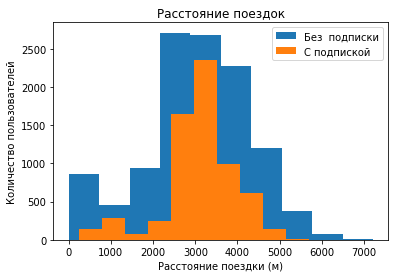

In [27]:
# расстояние поездок пользователей без подписки и с 

ax = subscription_free['distance'].plot(kind='hist', label='a') # синий
subscription_ultra['distance'].plot(kind='hist', label='b') # оранжевый

plt.title('Расстояние поездок')
plt.ylabel('Количество пользователей')
plt.xlabel('Расстояние поездки (м)')
ax.legend(["Без  подписки", "С подпиской"]);
plt.show()

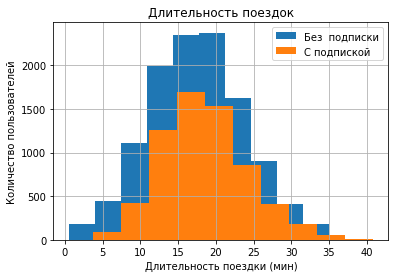

In [28]:
# длительность поездок пользователей без подписки и с 

ax = subscription_free['duration'].hist() # синий
subscription_ultra['duration'].hist() # оранжевый

plt.title('Длительность поездок')
plt.ylabel('Количество пользователей')
plt.xlabel('Длительность поездки (мин)')
ax.legend(["Без  подписки", "С подпиской"]);
plt.show()

##### Вывод

1. Три исходных датафрейма объединены в один с названием data.
2. Данные о пользователях с подпиской выделены в датафрейм subscription_ultra, без подписки - subscription_free.
3. Построены гистограммы по расстоянию и длительности поездок отдельно для subscription_ultra и subscription_free.

Показатели duration для subscription_ultra и subscription_free нормально  распределены. Гистограммы distance для каждого типа подписки имеют два пика: в районе 500-1000 метров и 3000 метров. Если отбросить первый пик значений, то распределение станет похоже на нормальное.

Средняя длительность поездки для обеих типов подписок 15-20 минут. 95% поездок имеют длительноть в пределах 5-30 минут, а самые длительные имеют продолжительность около 40 минут.

#### Шаг 5. Подсчёт выручки

In [29]:
# каждое значение из столбца duration округляется с помощью «потолка»:
data['duration'] = np.ceil(data['duration'])

In [30]:
# проверка на пропуски
data.isnull().sum().sum()

0

In [31]:
# создадим датафрейм user_data, содержащий:
# суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц

user_data = data.groupby(['user_id', 'month']).agg({'distance': 'sum', 'user_id': 'count','duration': 'sum'})
user_data = pd.DataFrame(user_data)
user_data.rename(columns={'user_id': 'rides'}, inplace=True)
user_data.reset_index(inplace= True)

user_data

,user_id,month,distance,rides,duration
0,1,1,7027.511294,2,42.0
1,1,4,754.159807,1,7.0
2,1,8,6723.470560,2,46.0
3,1,10,5809.911100,2,32.0
4,1,11,7003.499363,3,56.0
...,...,...,...,...,...
11326,1534,6,3409.468534,2,26.0
11327,1534,8,7622.453034,2,48.0
11328,1534,9,4928.173852,1,23.0
11329,1534,11,13350.015305,4,78.0


In [32]:
# помесячная выручка с каждого пользователя
user_data['subscription_type'] = np.where(user_data['user_id'] < 700, 1, 0)

user_data['proceeds'] = np.where(user_data['subscription_type'] == 1, \
                                 subscriptions['subscription_fee'][1] + \
                                 user_data['rides'] * subscriptions['start_ride_price'][1] + \
                                 user_data['duration'] * subscriptions['minute_price'][1], \
                                 subscriptions['subscription_fee'][0] + \
                                 user_data['rides'] * subscriptions['start_ride_price'][0] + \
                                 user_data['duration'] * subscriptions['minute_price'][0])

user_data

,user_id,month,distance,rides,duration,subscription_type,proceeds
0,1,1,7027.511294,2,42.0,1,451.0
1,1,4,754.159807,1,7.0,1,241.0
2,1,8,6723.470560,2,46.0,1,475.0
3,1,10,5809.911100,2,32.0,1,391.0
4,1,11,7003.499363,3,56.0,1,535.0
...,...,...,...,...,...,...,...
11326,1534,6,3409.468534,2,26.0,0,308.0
11327,1534,8,7622.453034,2,48.0,0,484.0
11328,1534,9,4928.173852,1,23.0,0,234.0
11329,1534,11,13350.015305,4,78.0,0,824.0


##### Вывод
1. Был создан датафрейм user_data, содержащий суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.
2. Значения столбца duration данного датафрейма были округлены в большую сторону.
3. Добавлен столбец proceeds с помесячной выручкой с каждого пользователя.

#### Шаг 6. Проверка гипотез

##### Гипотеза №1

Нулевая гипотеза: длительность поездок пользователей с подпиской равна длительности поездок пользователей без подписки.

Альтернативная гипотеза: длительность поездок пользователей с подпиской больше длительности поездок пользователей без подписки.

In [33]:
alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(subscription_ultra['duration'], subscription_free['duration'], alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергать нулевую гипотезу') 

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


Полученное значение p-value 1.6e-34 меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. 
Есть основания говорить, что пользователи с подпиской тратят больше времени на поездки.

##### Гипотеза №2

Нулевая гипотеза: расстояние, которое проезжают пользователи с подпиской за одну поездку, равно 3130 метров.

Альтернативная гипотеза: расстояние, которое проезжают пользователи с подпиской за одну поездку, больше 3130 метров.

In [34]:
optimal_distance = 3130

results = st.ttest_1samp(
    subscription_ultra['distance'], 
    optimal_distance,
      alternative='greater')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу: расстояние больше 3130 метров')
else:
    print('Не получилось отвергнуть нулевую гипотезу: расстояние меньше или равно 3130 метров')

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу: расстояние меньше или равно 3130 метров


Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров. Значит, самокаты не будут изнашиваться слишком быстро.

##### Гипотеза №3

Нулевая гипотеза: помесячная выручка от пользователей с подпиской по месяцам равна выручке от пользователей без подписки. 

Альтернативная гипотеза: помесячная выручка от пользователей с подпиской по месяцам больше выручки от пользователей без подписки. 

In [35]:
# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(user_data.query('subscription_type == 1')['proceeds'], user_data.query('subscription_type == 0')['proceeds'], alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергать нулевую гипотезу')

p-value: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


Помесячная выручка от пользователей с подпиской по месяцам будет выше, чем выручка от пользователей без подписки. 
Следовательно, стоит увеличить количество пользователей с подпиской с помощью акций.

##### Гипотеза №4

Техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Для проверки использовалась бы гипотеза о равенстве средних для зависимых (парных) выборок, тест scipy.stats.ttest_rel.

##### Вывод
1. Пользователи с подпиской тратят больше времени на поездки.
2. Расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров. Значит, самокаты не будут изнашиваться слишком быстро. 
3. Помесячная выручка от пользователей с подпиской по месяцам будет выше, чем выручка от пользователей без подписки. Следовательно, стоит увеличить количество пользователей с подпиской с помощью акций.

Выводы 1, 2 сделаны на основании проверки двусторонней гипотезы, вывод 3 - на основании проверки гипотезы о равенстве средних двух генеральных совокупностей.

#### Шаг 7. Общий вывод

Были проведены следующие действия: выгружены данные из файлов в датасеты, датасеты проверены на пропуски и дубликаты, удалеены найденные дубликаты, три датасета объединены в один, построены и исследованы графики по необходимым показателям, рассчитана выручка, проверены гипотезы для принятия решений по увеличению прибыли.

1. Столбец date приведен к типу даты pandas. Создан новый столбец month с номером месяца на основе столбца date.

2. Удалены явные дубликаты из таблицы users.

3. Указанные города Тюмень, Омск, Москва, Ростов-на-Дону, Краснодар, Пятигорск, Екатеринбург, Сочи встречаются в данных с приблизительно одинаковой частотой. Чаще всего встречается Пятигорск (226 пользователей указали данный город), реже всего - Москва (172 упоминания). Остальные города упоминаются 185-206 раз.

4. Пользователей без подписки оказалось 54% от общего числа пользователей. Пользователей с подпиской немного меньше - 46%.

Тип подписки | Доля от общего числа
:----------- | :-------------------
free         | 54%
ultra        | 46%

5. Возраст пользователей распределен нормально. Средний возраст пользователя равен 25 лет. Всего в данных встречаются пользователи в возрасте от 12 до 43 лет включительно. 95% пользователей будет в диапазоне 16-35 лет.

6. На графике расстояния видно два пика:  3100 и 500  метров. Полагаю, пик в 500 метров связан с неработающими/плохо  работающими самокатами или же пользователями, передумавшими совершать поездку или просто желающими попробовать встать на самокат. То есть, скорее всего, эти поездки не являются полноценными. Если не смотреть на пик в 500 метров, то распределение расстояний похоже на нормальное с мат. ожиданием 3100 метров и стандартным отклонением около 1200 метров, то есть 95% полноценных поездок будут в диапазоне 800-5400 метров. Самые далекие поездки совершаются  на расстояние до 7000 метров.

7. Три исходных датафрейма объединены в один с названием data. Данные о пользователях с подпиской выделены в датафрейм subscription_ultra, без подписки - subscription_free.

8. Показатели duration (длительность поездки) для subscription_ultra и subscription_free нормально распределены. Гистограммы distance (расстояние поездки) для каждого типа подписки имеют два пика: в районе 500-1000 метров и 3000 метров. Если отбросить первый пик значений, то распределение станет похоже на нормальное.

9. Средняя длительность поездки для обеих типов подписок 15-20 минут. 95% поездок имеют длительноть в пределах 5-30 минут, а самые длительные имеют продолжительность около 40 минут. 

10. Был создан датафрейм user_data, содержащий суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц. Значения столбца duration данного датафрейма были округлены в большую сторону. Добавлен столбец proceeds с помесячной выручкой с каждого пользователя. 

11. Пользователи с подпиской тратят больше времени на поездки.

12. Среднее  расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров. Значит, самокаты не будут изнашиваться слишком быстро.

13. Помесячная выручка от пользователей с подпиской по месяцам будет выше, чем выручка от пользователей без подписки. Следовательно, стоит увеличить количество пользователей с подпиской с помощью акций.